## Opis problemu

Znajdź dowolny zbiór danych (dozwolone języki: angielski, hiszpański, polski, szwedzki) (poza IMDB oraz zbiorami wykorzystywanymi na zajęciach) do analizy sentymentu.
Zbiór może mieć 2 lub 3 klasy.

Następnie:
1. Oczyść dane i zaprezentuj rozkład klas
2. Zbuduj model analizy sentymenu:
  - z wykorzystaniem sieci rekurencyjnej (LSTM/GRU/sieć dwukierunkowa) innej niż podstawowe RNN
  - z wykorzystaniem sieci CNN
  - z podstawiemiem pre-trained word embeddingów
  - z fine-tuningiem modelu języka (poza podstawowym BERTem)

3. Stwórz funkcję, która będzie korzystała z wytrenowanego modelu i zwracała wynik dla przekazanego pojedynczego zdania (zdań) w postaci komunikatu informującego użytkownika, czy tekst jest nacechowany negatywnie, pozytywnie (czy neutralnie w przypadku 3 klas).

4. Gotowe rozwiązanie zamieść na GitHubie z README. W README zawrzyj: informacje o danych - ich pochodzenie, oraz opis wybranego modelu i instrukcje korzystania z plików.
5. W assigmnencie w Teamsach wrzuć link do repo z rozwiązaniem. W przypadku prywatnego repo upewnij się, że będzie ono widoczne dla `dwnuk@pjwstk.edu.pl`.

**TERMIN**: jak w Teamsach

In [8]:
#!conda install -y nltk seaborn catboost anaconda::pandas

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /home/karol/anaconda3/envs/Archive1

  added / updated specs:
    - anaconda::pandas
    - catboost
    - nltk
    - seaborn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-2.1.1               |  py311ha02d727_0        16.2 MB  anaconda
    ------------------------------------------------------------
                                           Total:        16.2 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  pandas        

In [12]:
#Zadanie 1 i 2.1
import re
import warnings

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier,Lasso,LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D, SpatialDropout1D, LSTM, MaxPooling3D
from keras.callbacks import EarlyStopping

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

import string
import seaborn as sns
from string import punctuation
from os import listdir
from numpy import array, asarray, zeros
from collections import Counter

from sklearn.pipeline import Pipeline
from wordcloud import STOPWORDS

ModuleNotFoundError: No module named 'pandas'

In [13]:
nltk.download('punkt')  # Punkt Tokenizer Model
nltk.download('stopwords')  # Stopwords
nltk.download('wordnet')  # WordNet Lemmatizer

NameError: name 'nltk' is not defined

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
# Remove duplicates based on the 'Sentence' column
df = df.drop_duplicates(subset='Sentence')

# Lowercase the sentences
df['Sentence'] = df['Sentence'].str.lower()

# Remove punctuation
df['Sentence'] = df['Sentence'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Tokenize the sentences
df['Sentence'] = df['Sentence'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Sentence'] = df['Sentence'].apply(lambda x: [word for word in x if word not in stop_words])

# Lemmatize the words
lemmatizer = WordNetLemmatizer()
df['Sentence'] = df['Sentence'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))


In [6]:
# The number of most frequent words to consider
MAX_NB_WORDS = 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 250
# This is fixed
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [7]:
# Convert sentiments to one-hot vectors
encoder = LabelEncoder()
encoder.fit(df['Sentiment'])
Y = encoder.transform(df['Sentiment'])
Y = to_categorical(Y)

In [8]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.10, random_state = 42)

In [9]:
# Create model
lsts_model = Sequential()
lsts_model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
lsts_model.add(SpatialDropout1D(0.2))
lsts_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lsts_model.add(Dense(3, activation='softmax'))  # 3 is the number of sentiment classes
lsts_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
# Train model
epochs = 5
batch_size = 64

history = lsts_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
68/68 [==============================] - 22s 288ms/step - loss: 0.9509 - accuracy: 0.5457 - val_loss: 0.8589 - val_accuracy: 0.5741
Epoch 2/5
68/68 [==============================] - 26s 382ms/step - loss: 0.6939 - accuracy: 0.7135 - val_loss: 0.7141 - val_accuracy: 0.6889
Epoch 3/5
68/68 [==============================] - 28s 412ms/step - loss: 0.3850 - accuracy: 0.8522 - val_loss: 0.6690 - val_accuracy: 0.7098
Epoch 4/5
68/68 [==============================] - 30s 436ms/step - loss: 0.1894 - accuracy: 0.9353 - val_loss: 0.7422 - val_accuracy: 0.7244
Epoch 5/5
68/68 [==============================] - 33s 480ms/step - loss: 0.0951 - accuracy: 0.9668 - val_loss: 0.8758 - val_accuracy: 0.7307


In [11]:
# Evaluate the model
accr = lsts_model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

17/17 [==============================] - 1s 68ms/step - loss: 0.8615 - accuracy: 0.7486
Test set
  Loss: 0.862
  Accuracy: 0.749


17/17 [==============================] - 2s 77ms/step


<Axes: >

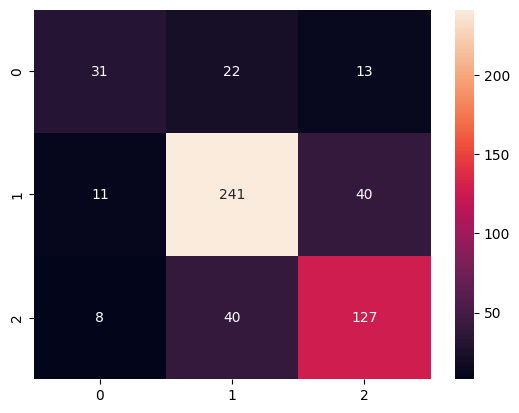

In [12]:
# Predict the sentiments for the test set
Y_pred = lsts_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt="d")

In [13]:
# Define your labels based on the order of your sentiment classes
labels = ['negative', 'neutral', 'positive']

# Generate a classification report
report = classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=labels)
print(report)

              precision    recall  f1-score   support

    negative       0.62      0.47      0.53        66
     neutral       0.80      0.83      0.81       292
    positive       0.71      0.73      0.72       175

    accuracy                           0.75       533
   macro avg       0.71      0.67      0.69       533
weighted avg       0.74      0.75      0.74       533


In [14]:
# Assuming that 'text_to_predict' is the text for which you want to predict the sentiment
text_to_predict = ["The stock market is doing great today!"]
sequences = tokenizer.texts_to_sequences(text_to_predict)
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
pred = lsts_model.predict(padded)
labels = ['negative', 'neutral', 'positive']
print("Predicted sentiment: ", labels[np.argmax(pred)])

1/1 [==============================] - 0s 72ms/step
Predicted sentiment:  positive


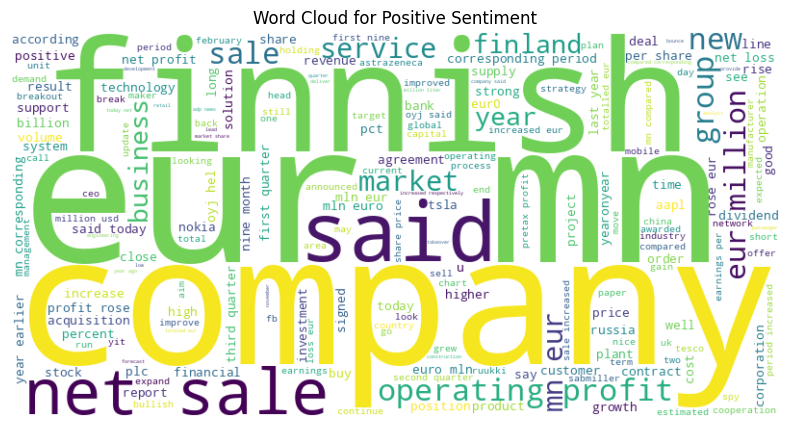

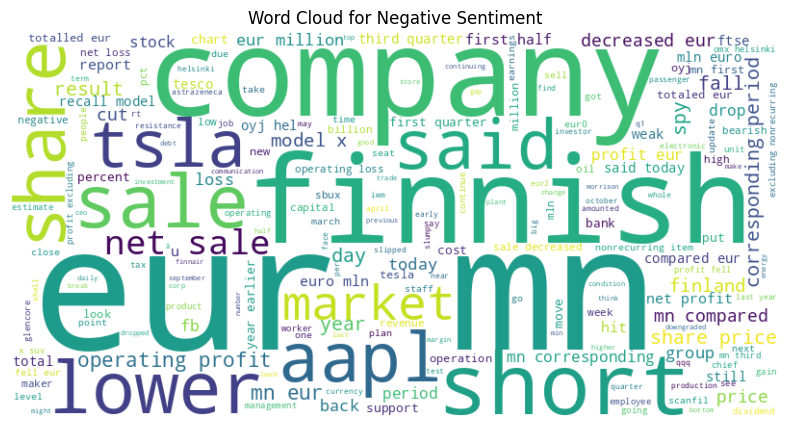

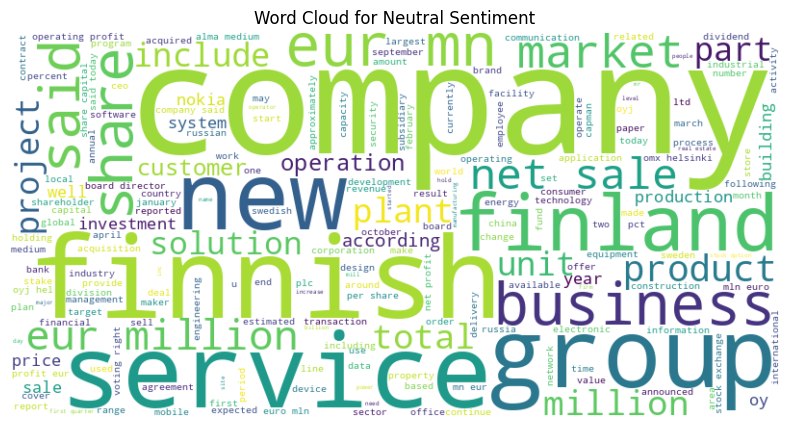

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def visualize_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

for sentiment in ['positive', 'negative', 'neutral']:
    text = ' '.join(df[df['Sentiment'] == sentiment]['Sentence'].tolist())
    visualize_wordcloud(text, f'Word Cloud for {sentiment.capitalize()} Sentiment')

In [16]:
# Zadanie 2.2 i 2.3
def load_embedding(filename):
    file = open(filename,'r')
    lines = file.readlines()
    file.close()
    embedding = dict()
    for line in lines:
        parts = line.split()
        embedding[parts[0]] = asarray(parts[1:], dtype='float32')
        return embedding
 
def get_weight_matrix(embedding, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = zeros((vocab_size, 100))
    for word, i in vocab.items():
        vector = embedding.get(word)
        if vector is not None:
            weight_matrix[i] = vector
            
    return weight_matrix

max_length = max([len(s) for s in X_train])
vocab_size = len(tokenizer.word_index) + 1
 
raw_embedding = load_embedding('glove.6B.100d.txt')
embedding_vectors = get_weight_matrix(raw_embedding, tokenizer.word_index)
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_vectors], input_length=max_length, trainable=False)
 
print(X_train[:10])
print(Y_train[:10])

cnn_model = Sequential()
cnn_model.add(embedding_layer)
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=3))
cnn_model.add(Flatten())
cnn_model.add(Dense(3, activation='softmax'))
print(cnn_model.summary())
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_model.fit(X_train, Y_train, epochs=10, verbose=2)
loss, acc = cnn_model.evaluate(X_test, Y_test, verbose=0)
print('Test Accuracy: %f' % (acc*100))

[[   0    0    0 ...   11 3793    1]
 [   0    0    0 ...    1 1149    4]
 [   0    0    0 ...  283  432   45]
 ...
 [   0    0    0 ...  148 4567   67]
 [   0    0    0 ...  249   14  968]
 [   0    0    0 ...  210   61   78]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 100)          1170400   
                                                                 
 conv1d (Conv1D)             (None, 246, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 82, 128)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None,

In [17]:
# Zadanie 2.4
from catboost import CatBoostClassifier,Pool
X_train, X_test, y_train, y_test = train_test_split(df.Sentence, df.Sentiment, test_size=0.3, random_state=8)

X_trainDF = pd.DataFrame(X_train.values,columns=['text'])
X_testDF = pd.DataFrame(X_test.values,columns=['text'])

text_features = ['text']

learn_pool = Pool(
    X_trainDF, 
    y_train, 
    # cat_features = [0],
    text_features=text_features, 
    feature_names=list(X_trainDF),
)
test_pool = Pool(
    X_testDF, 
    y_test, 
    # cat_features = [0],
    text_features=text_features, 
    feature_names=list(X_trainDF),   
)
params = {
'iterations':1000, 
'learning_rate':0.0733648494628464,
'l2_leaf_reg': 2.073037214371847,
'od_type' :"Iter",
'thread_count':6,
# 'custom_metric':'TotalF1',
'loss_function':'MultiClass',
'eval_metric':'TotalF1',
'text_processing':['NaiveBayes+Word|BoW+Word'],
'use_best_model':True,
# 'classes_count':3,
'depth':8,
'random_seed':8,
'early_stopping_rounds':44,
'grow_policy':'SymmetricTree',
'score_function':'L2',
'leaf_estimation_backtracking':'AnyImprovement',
'leaf_estimation_method':'Gradient',
'bootstrap_type': 'MVS',

# 'auto_class_weights':'SqrtBalanced'
}
catboost_model = CatBoostClassifier(**params)
catboost_model.fit(learn_pool, eval_set=test_pool, verbose=50,plot=True)
print(classification_report(catboost_model.predict(X_testDF),y_test))


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6725519	test: 0.6971241	best: 0.6971241 (0)	total: 346ms	remaining: 5m 45s
50:	learn: 0.7253971	test: 0.7106621	best: 0.7115738 (46)	total: 14.2s	remaining: 4m 24s
100:	learn: 0.7638898	test: 0.7244083	best: 0.7260905 (95)	total: 28.5s	remaining: 4m 13s
150:	learn: 0.7951445	test: 0.7288552	best: 0.7294195 (148)	total: 42.8s	remaining: 4m
200:	learn: 0.8240712	test: 0.7361923	best: 0.7380627 (184)	total: 57.3s	remaining: 3m 47s
Stopped by overfitting detector  (44 iterations wait)

bestTest = 0.7380627496
bestIteration = 184

Shrink model to first 185 iterations.
              precision    recall  f1-score   support

    negative       0.28      0.58      0.37        84
     neutral       0.88      0.79      0.83       993
    positive       0.70      0.71      0.70       520

    accuracy                           0.75      1597
   macro avg       0.62      0.69      0.64      1597
weighted avg       0.79      0.75      0.77      1597


In [29]:
# Zadanie 3
def lstm_predict(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    pred = lsts_model.predict(padded)
    labels = ['negative', 'neutral', 'positive']
    print("LSTS - Predicted sentiment: ", labels[np.argmax(pred)])

def catboost_predict(text):
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    pred = catboost_model.predict(padded)
    labels = ['negative', 'neutral', 'positive']
    print("CATBOOST - Predicted sentiment: ", labels[np.argmax(pred)])

lstm_predict(["The stock market is doing great today!"])
lstm_predict(["The stock market is doing terrible today!"])
lstm_predict(["The stock market is going down"])

catboost_predict(["The stock market is doing great today!"])
catboost_predict(["The stock market is doing terrible today!"])
catboost_predict(["The stock market is going down"])

1/1 [==============================] - 0s 88ms/step
LSTS - Predicted sentiment:  positive
1/1 [==============================] - 0s 84ms/step
LSTS - Predicted sentiment:  neutral
1/1 [==============================] - 0s 84ms/step
LSTS - Predicted sentiment:  neutral
CATBOOST - Predicted sentiment:  negative
CATBOOST - Predicted sentiment:  negative
CATBOOST - Predicted sentiment:  negative


In [ ]:
print('test')